In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import pandas as pd
from fastcore.xtras import load_pickle

from gptchem.data import get_photoswitch_data
from gptchem.evaluator import evaluate_photoswitch_smiles_pred, evaluate_generated_smiles

from gptchem.settings import ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH

from guacamol.utils.chemistry import is_valid
from glob import glob
import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science', 'nature'])

import matplotx


%matplotlib inline

In [52]:
from rdkit import Chem

In [53]:
all_res = glob('out/**/*.pkl')

In [54]:
res = load_pickle(all_res[0])

In [55]:
from collections import defaultdict

In [56]:
def contains_azo(smiles):
    mol = Chem.MolFromSmiles(smiles)
    # check if there is a N#N bond
    smarts = "[NX2]=N"
    return mol.HasSubstructMatch(Chem.MolFromSmarts(smarts))

In [57]:
compiled_res = []
generated_smiles = set()
generated_smiles_w_azos = set()

generated_smiles_w_azos_at_temp = defaultdict(set)
generated_smiles_at_temp = defaultdict(set)

for res_path in all_res:
    res = load_pickle(res_path)
    for temp_res in res['res_at_temp']:


        metrics= {
            'noise_level': res['noise_level'],
            'temp': temp_res['temperature'],
            'frac_valid': temp_res['frac_valid'],
            'frac_unique': temp_res['frac_unique'],
            'frac_smiles_in_train': temp_res['frac_smiles_in_train'],
            'frac_smiles_in_pubchem': temp_res['frac_smiles_in_pubchem'],
            'kld': temp_res['kld'],
            'frechet_d': temp_res['frechet_d'],
            'frechet_score': temp_res['frechet_score'],
            'frac_contains_azo': sum([contains_azo(s) for s in temp_res['valid_smiles']]) / len(temp_res['valid_smiles']),
        }

        generated_smiles.update([s for s in temp_res['generated_smiles'] if is_valid(s)])
        v_w_azo = [s for s in temp_res['generated_smiles'] if is_valid(s) and contains_azo(s)]
        generated_smiles_w_azos.update(v_w_azo)
        generated_smiles_w_azos_at_temp[temp_res['temperature']].update(v_w_azo)


        v = [s for s in temp_res['generated_smiles'] if is_valid(s)]
        generated_smiles_at_temp[temp_res['temperature']].update(v)

        for me, v in temp_res['e_pi_pi_star_metrics'].items():
            metrics["e_pi_pi_star_" + me] = v

        for me, v in temp_res['z_pi_pi_star_metrics'].items():
            metrics["z_pi_pi_star_" + me] = v
        compiled_res.append(metrics)

In [58]:
contains_azo(list(generated_smiles)[5])

True

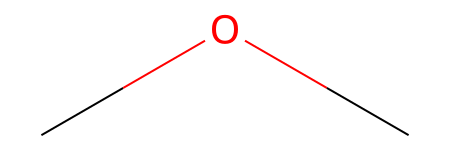

In [59]:
Chem.MolFromSmiles(list(generated_smiles)[0])

In [60]:
df = pd.DataFrame(compiled_res)

In [61]:
grouped = df.groupby(['temp']).agg(['mean', 'std'])

In [62]:
grouped

noise_level           frac_valid           frac_unique            \
            mean       std       mean       std        mean       std   
temp                                                                    
0.00       2.375  3.440826   0.995924  0.011529    0.025953  0.010072   
0.10       2.375  3.440826   0.991848  0.011251    0.045350  0.020318   
0.20       2.375  3.440826   0.975543  0.039298    0.109033  0.035998   
0.50       2.375  3.440826   0.971467  0.018315    0.364854  0.028913   
0.75       2.375  3.440826   0.914402  0.039592    0.554911  0.023796   
1.00       2.375  3.440826   0.692935  0.054114    0.752957  0.071289   
1.25       2.375  3.440826   0.342391  0.063380    0.897495  0.054707   
1.50       2.375  3.440826   0.108696  0.029625    1.000000  0.000000   
2.00       2.375  3.440826   0.130435  0.041083    1.000000  0.000000   

     frac_smiles_in_train      frac_smiles_in_pubchem            ...  \
                     mean  std                   mean       std  ...   
temp                                                             ...   
0.00                  0.0  0.0               1.000000  0.000000  ...   
0.10                  0.0  0.0               1.000000  0.000000  ...   
0.20                  0.0  0.0               1.000000  0.000000  ...   
0.50                  0.0  0.0               1.000000  0.000000  ...   
0.75                  0.0  0.0               1.000000  0.000000  ...   
1.00                  0.0  0.0               1.000000  0.000000  ...   
1.25                  0.0  0.0               1.000000  0.000000  ...   
1.50                  0.0  0.0               1.000000  0.000000  ...   
2.00                  0.0  0.0               0.979167  0.058926  ...   

     z_pi_pi_star_r2           z_pi_pi_star_max_error             \
                mean       std                   mean        std   
temp                                                               
0.00       -0.019551  0.049992              52.146474   3.031616   
0.10       -0.039051  0.035264              52.540281   3.657073   
0.20       -0.078431  0.072170              53.751948   4.329762   
0.50       -0.171761  0.084941              60.099580   6.357657   
0.75       -0.262193  0.150131              67.661231  13.097945   
1.00       -0.403172  0.196098              67.993861   8.944947   
1.25       -0.699172  0.468916              56.607614   7.397753   
1.50       -4.222145  5.414800              52.728697   7.437472   
2.00       -5.829693  4.001700              61.765966  12.527507   

     z_pi_pi_star_mean_absolute_error            \
                                 mean       std   
temp                                              
0.00                        13.582005  1.117144   
0.10                        13.765590  0.907673   
0.20                        14.048516  0.932031   
0.50                        14.570727  1.227767   
0.75                        14.636907  1.295736   
1.00                        15.680546  1.799866   
1.25                        16.902062  2.520160   
1.50                        25.620209  3.543218   
2.00                        33.271719  4.076855   

     z_pi_pi_star_mean_squared_error             z_pi_pi_star_rmse            
                                mean         std              mean       std  
temp                                                                          
0.00                      332.991150   35.258395         18.226821  0.940602  
0.10                      340.616751   27.808826         18.443177  0.729742  
0.20                      354.275170   33.261576         18.804906  0.862349  
0.50                      387.174227   52.960583         19.638155  1.316753  
0.75                      412.765260   79.506963         20.235248  1.942013  
1.00                      474.480530   81.197308         21.717218  1.802523  
1.25                      494.161749  101.100860         22.112341  2.439237  
1.50                      933.849692  165.4

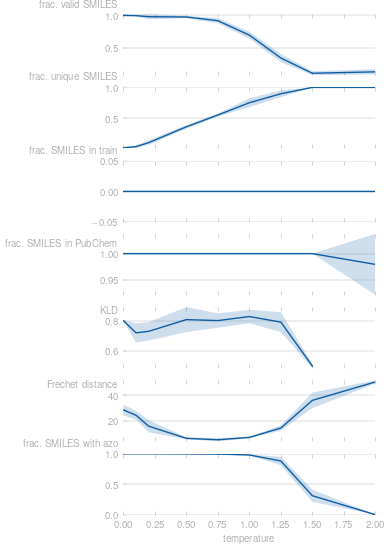

In [63]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(7,1, sharex='all', figsize=(ONE_COL_WIDTH_INCH, 2*ONE_COL_WIDTH_INCH))
    ax[0].plot(grouped.index, grouped['frac_valid']['mean'], label='frac_valid')
    ax[0].fill_between(grouped.index, grouped['frac_valid']['mean'] - grouped['frac_valid']['std'], grouped['frac_valid']['mean'] + grouped['frac_valid']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. valid SMILES', ax=ax[0])

    ax[1].plot(grouped.index, grouped['frac_unique']['mean'], label='frac_unique')
    ax[1].fill_between(grouped.index, grouped['frac_unique']['mean'] - grouped['frac_unique']['std'], grouped['frac_unique']['mean'] + grouped['frac_unique']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. unique SMILES', ax=ax[1])

    ax[2].plot(grouped.index, grouped['frac_smiles_in_train']['mean'], label='frac_smiles_in_train')
    ax[2].fill_between(grouped.index, grouped['frac_smiles_in_train']['mean'] - grouped['frac_smiles_in_train']['std'], grouped['frac_smiles_in_train']['mean'] + grouped['frac_smiles_in_train']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. SMILES in train', ax=ax[2])

    ax[3].plot(grouped.index, grouped['frac_smiles_in_pubchem']['mean'], label='frac_smiles_in_pubchem')
    ax[3].fill_between(grouped.index, grouped['frac_smiles_in_pubchem']['mean'] - grouped['frac_smiles_in_pubchem']['std'], grouped['frac_smiles_in_pubchem']['mean'] + grouped['frac_smiles_in_pubchem']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. SMILES in PubChem', ax=ax[3])

    ax[4].plot(grouped.index, grouped['kld']['mean'], label='kld')
    ax[4].fill_between(grouped.index, grouped['kld']['mean'] - grouped['kld']['std'], grouped['kld']['mean'] + grouped['kld']['std'], alpha=0.2)

    matplotx.ylabel_top('KLD', ax=ax[4])

    ax[5].plot(grouped.index, grouped['frechet_d']['mean'], label='frechet_d')
    ax[5].fill_between(grouped.index, grouped['frechet_d']['mean'] - grouped['frechet_d']['std'], grouped['frechet_d']['mean'] + grouped['frechet_d']['std'], alpha=0.2)

    matplotx.ylabel_top('Frechet distance', ax=ax[5])

    ax[6].plot(grouped.index, grouped['frac_contains_azo']['mean'], label='frechet_score')
    ax[6].fill_between(grouped.index, grouped['frac_contains_azo']['mean'] - grouped['frac_contains_azo']['std'], grouped['frac_contains_azo']['mean'] + grouped['frac_contains_azo']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. SMILES with azo', ax=ax[6])

    ax[-1].set_xlabel('temperature', labelpad=4)

    fig.savefig('photoswitch_random_smiles_metrics.pdf', bbox_inches='tight')

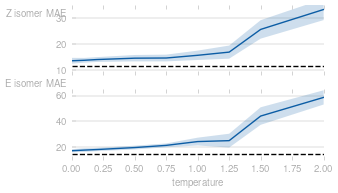

In [64]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(2,1, sharex='all', figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))

    ax[0].plot(grouped.index, grouped['z_pi_pi_star_mean_absolute_error']['mean'], label='e_pi_pi_star_metrics')
    ax[0].fill_between(grouped.index, grouped['z_pi_pi_star_mean_absolute_error']['mean'] - grouped['z_pi_pi_star_mean_absolute_error']['std'], grouped['z_pi_pi_star_mean_absolute_error']['mean'] + grouped['z_pi_pi_star_mean_absolute_error']['std'], alpha=0.2)

    matplotx.ylabel_top('Z isomer MAE', ax=ax[0])

    ax[0].hlines(11.616605626696359, 0, 2, color='k', linestyle='--')

    ax[0].set_ylim(8,35)

    ax[1].plot(grouped.index, grouped['e_pi_pi_star_mean_absolute_error']['mean'], label='e_pi_pi_star_metrics')
    ax[1].fill_between(grouped.index, grouped['e_pi_pi_star_mean_absolute_error']['mean'] - grouped['e_pi_pi_star_mean_absolute_error']['std'], grouped['e_pi_pi_star_mean_absolute_error']['mean'] + grouped['e_pi_pi_star_mean_absolute_error']['std'], alpha=0.2)

    matplotx.ylabel_top('E isomer MAE', ax=ax[1])

    ax[1].hlines(14.38998132190228, 0, 2, color='k', linestyle='--')

    ax[-1].set_xlabel('temperature', labelpad=4)
    ax[1].set_ylim(10,65)
fig.savefig('random_photoswitch_constrain_matches.pdf', bbox_inches='tight')

## Visualize

In [65]:
import tmap as tm
import numpy as np

from faerun import Faerun
from mhfp.encoder import MHFPEncoder
from rdkit.Chem import AllChem

from tqdm import tqdm

In [66]:
import os
import shutil

In [67]:
def make_figure(temp):
    path = f"plots_all/{temp}"
    os.makedirs(path, exist_ok=True)
    enc = MHFPEncoder()
    lf = tm.LSHForest(2048, 128)
    train_data = get_photoswitch_data()
    train_smiles = train_data['SMILES'].values
    all_smiles = set(train_smiles) | generated_smiles_at_temp[temp]

    fps = []
    labels = []

    for smiles in tqdm(all_smiles):
        mol = AllChem.MolFromSmiles(smiles)
        fps.append(tm.VectorUint(enc.encode_mol(mol, min_radius=0)))
        labels.append(smiles in train_smiles)

    lf.batch_add(fps)
    lf.index()
    cfg = tm.LayoutConfiguration()
    cfg.k = 100
    cfg.sl_extra_scaling_steps = 6
    cfg.sl_repeats = 2
    cfg.mmm_repeats = 2
    cfg.node_size = 2
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, config=cfg)

    f = Faerun(
    clear_color="#FFFFFF",
    coords=False,
    view="free",
    impress='made with <a href="http://tmap.gdb.tools" target="_blank">tmap</a><br />and <a href="https://github.com/reymond-group/faerun-python" target="_blank">faerun</a>',
    )
    f.add_scatter(
        f"Photoswitches",
        {
            "x": x,
            "y": y,
            "c": labels,
            "labels": all_smiles,
        },
        colormap="Set1",
        categorical=True,
        shader='sphere',
        has_legend=True,
        point_scale=5,
        legend_labels=[(1, "in database"), (0, "not in database")],
        max_point_size=5000
    )
    f.add_tree(
        "Photoswitches_tree",
        {
            "from": s,
            "to": t,
        },
        point_helper="Photoswitches",
    )
    f.plot("Photoswitches", template="smiles")

    shutil.copy("Photoswitches.html", path)

In [68]:
for temp in [0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]:
    make_figure(temp)

100%|██████████| 403/403 [00:03<00:00, 102.31it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 403/403 [00:03<00:00, 104.63it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 404/404 [00:03<00:00, 104.61it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 427/427 [00:04<00:00, 101.42it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 482/482 [00:04<00:00, 105.18it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 550/550 [00:05<00:00, 107.04it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 530/530 [00:04<00:00, 106.41it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 469/469 [00:04<00:00, 104.95it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 498/498 [00:04<00:00, 115.09it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

In [69]:
make_figure(1.5)

100%|██████████| 469/469 [00:04<00:00, 103.96it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html